# Análisis de ventas de libros CENGAGE

- Análisis de Ciencias de Datos
- Profesores:
  - Rubí Isela Gutiérrez López
  - Daniel Otero Fadul
- Equipo 4

| Nombre | Matrícula |
| ---- | ---- |
| Juan Pablo Echeagaray González | A00830646 |

Fecha: Por definir


## Meta de investigación

- Predecir el comportamiento de las ventas en un mundo post-pandémico

In [157]:
# Dependencias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.signal import find_peaks
plt.style.use('ggplot')


## Lectura de datos

In [158]:
df = pd.read_csv('datos-reto.csv')
# La primera columna es un índice, no se necesita mantener
df.drop(df.columns[[0]], axis=1, inplace=True)


## Preprocesamiento de datos

In [159]:
df.head()


,Country,Consultant,Opportunity ID,Account,ISBN 13,Author,Title,Probability,% de Avance,Term,...,Adjusted Revenue,Technology,Course Name,Edition,Course ID,# of Courses,Customer,Client,Unlimited Flag,Implementation Id
0,Mexico,14,5255970,COLEGIO DE BACHILLERES DE CHIHUAHUA,9.786075e+12,Martinez,Literatura II,No_Aceptada,0,Aug-21,...,0,NaN,LITERATURA COBACH,1.0,1847125,NaN,Potential Customer,3705,NaN,NaN
1,Mexico,10,5172372,U-ERRE UNIVERSIDAD REGIOMONTANA,9.781338e+12,Serway/Vuille,INTL IAC WA FUNDAMENTOS DE FIS ICA,Closed Sale,1,Jan-21,...,0,WebAssign,FISICA 1 PREPA U-ERRE,11.0,1905363,NaN,Potential Customer,3681,NaN,NaN
2,Mexico,6,4496314,ITESM CAMPUS MONTERREY,9.786075e+12,CENGAGE,BIBLIOTECA DIGITAL MAGELLAN,No_Aceptada,0,Sep-20,...,0,NaN,BIBLIOTECA DIGITAL,1.0,1873177,NaN,Potential Customer,5929,NaN,NaN
3,Mexico,0,5745690,UNITEC CAMPUS CUITLAHUAC,9.786076e+12,GALINDO,MODELOS DE ORGANIZACIÓN,Evaluation Visit,0.75,May-22,...,0,NaN,Estructuras organizacionales y gestión del con...,1.0,1934416,NaN,Potential Customer,2538,NaN,NaN
4,Mexico,0,5745686,UNITEC CAMPUS CUITLAHUAC,9.786076e+12,GALINDO,MODELOS DE ORGANIZACIÓN,Evaluation Visit,0.75,Jan-22,...,0,NaN,Estructuras organizacionales y gestión del con...,1.0,1934416,NaN,Potential Customer,2538,NaN,NaN


In [160]:
df.columns


Index(['Country', 'Consultant', 'Opportunity ID', 'Account', 'ISBN 13',
       'Author', 'Title', 'Probability', '% de Avance ', 'Term',
       'New Course Takeaway Units', 'Seats', 'Units', 'Revenue',
       'Adjusted Revenue', 'Technology', 'Course Name', 'Edition', 'Course ID',
       '# of Courses', 'Customer', 'Client', 'Unlimited Flag',
       'Implementation Id'],
      dtype='object')

In [161]:
df.dtypes


Country                       object
Consultant                     int64
Opportunity ID                 int64
Account                       object
ISBN 13                      float64
Author                        object
Title                         object
Probability                   object
% de Avance                   object
Term                          object
New Course Takeaway Units    float64
Seats                          int64
Units                          int64
Revenue                      float64
Adjusted Revenue               int64
Technology                    object
Course Name                   object
Edition                      float64
Course ID                      int64
# of Courses                 float64
Customer                      object
Client                         int64
Unlimited Flag               float64
Implementation Id            float64
dtype: object

In [162]:
df['Term'].unique()

array(['Aug-21', 'Jan-21', 'Sep-20', 'May-22', 'Jan-22', 'Nov-20',
       'Aug-20', 'Aug-22', 'Mar-22', 'Sep-22', 'Dec-20', 'Feb-21',
       'Feb-22', 'Dec-21', 'Mar-21', 'Sep-21', 'Nov-22', 'Dec-22',
       'Nov-21', 'Jul-20', 'Apr-21', 'Jul-22', 'May-21', 'Jul-21',
       'Jun-22', 'Oct-20', 'Apr-22', 'Jun-20', 'Jun-21', 'Oct-21',
       'Oct-22'], dtype=object)

In [163]:
df.Technology.value_counts().sum() / df.shape[0]

0.12488938942965168

Solamente el 12% de los datos cuentan con una tecnología asociada. Deberíamos de mantener esta columna? Remplazarlos con algo que represente libros tradicionales

In [164]:
df.Probability.value_counts()

Closed Sale            5366
Muestra                4548
Base_Vendida           3877
No_Aceptada            2165
Base_Confirmada        2099
Interview              2097
Base_Por_Confirmar     1958
Evaluation Visit       1194
Identified Prospect    1100
Base_Perdida            363
Vendida                  60
Custom Adoption          29
At Risk                   6
Name: Probability, dtype: int64

¿Cómo mapear esta variable categórica? Hay niveles de jerarquía asociados? Se necesita ver de nuevo la reunión con el socio formador

### Remover columnas con valores NaN

Hay que investigar primero de qué están compuestas estas columnas. Si encontramos algunas con una proporción de valores nulos mayor a cierta tolerancia, no deberíamos de usarlas para la creación de un modelo predictivo

In [165]:
# Completamente arbitrario (yo pensaría que >50% sería mejor)
tresh = 0.7
nan_props = []
for col in df.columns:
    nan_props.append(df[col].isnull().sum() / len(df))
    

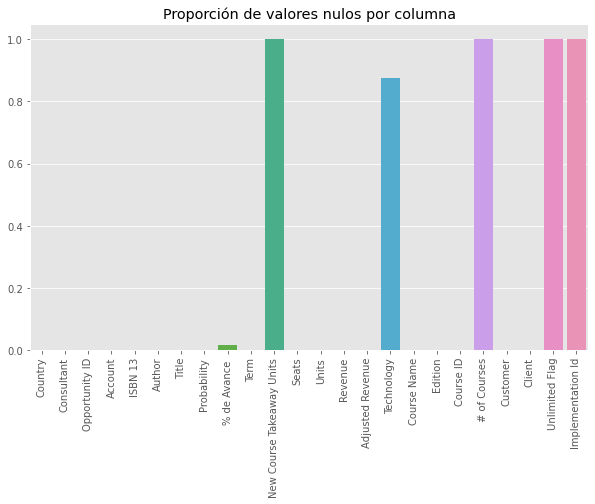

In [166]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df.columns, y=nan_props)
ax.set_title('Proporción de valores nulos por columna')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


5 de las 24 columnas de la base de datos tienen al menos un 80% de sus entradas con valores nulos, no podemos usarlas para generar un modelo predictivo.

In [167]:
# Remover todas las columnas con un porcentaje de nulos mayor al treshold
old_cols = df.columns
df.dropna(axis=1, thresh=tresh * df.shape[0], inplace=True)
new_cols = df.columns


In [168]:
old_cols.difference(new_cols)


Index(['# of Courses', 'Implementation Id', 'New Course Takeaway Units',
       'Technology', 'Unlimited Flag'],
      dtype='object')

Al final de este paso de limpieza hemos removido las anteriores columnas, ya que estaban compuestas de al menos un **70%** de valores NaN

### Conversión de `term` a formato `datetime`

Esta conversión facilitará la agregación y visualización de estos datos cuando entremos a la fase del análisis exploratorio de datos.

In [169]:
# Convertir a formato datetime la columna 'term'
df['Term'] = pd.to_datetime(df['Term'], format='%b-%y')


### Creación de _dummy variables_

## Exploratory Data Analysis

In [170]:
df['Adjusted Revenue'].describe()


count    24862.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Adjusted Revenue, dtype: float64

No podemos usar esta columna tal cual. Tal vez habría que ver con el socio formador si es que estos datos faltan; en caso de que sí, es casi imposible que nos regresen estos datos antes de que tengamos el tiempo encima

In [171]:
df.drop(['Adjusted Revenue'], axis=1, inplace=True)

### Investigando a los consultores

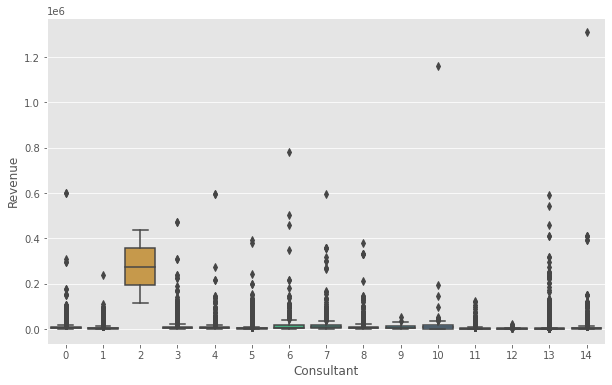

In [172]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Consultant', y='Revenue', data=df)


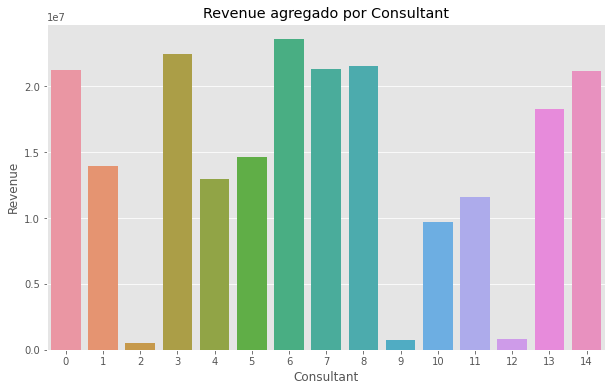

In [173]:
plt.figure(figsize=(10, 6))
agg_revenue = df.groupby('Consultant').sum()['Revenue']
ax = sns.barplot(x=agg_revenue.index, y=agg_revenue)
ax.set_title('Revenue agregado por Consultant');


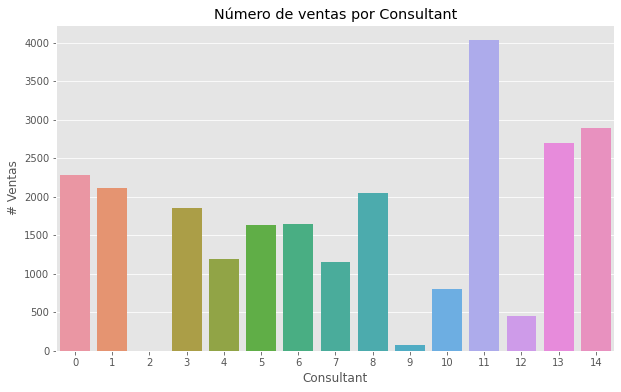

In [174]:
# Número de operaciones por consultant
plt.figure(figsize=(10, 6))
agg_ops = df['Consultant'].value_counts().sort_index()
ax = sns.barplot(x=agg_ops.index, y=agg_ops)
ax.set_title('Número de ventas por Consultant');
ax.set_ylabel('# Ventas');
ax.set_xlabel('Consultant');


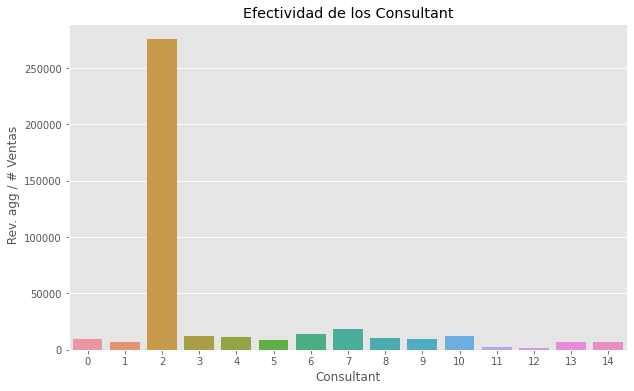

In [175]:
# Efectividad de los consultant? Revenue agregado / # operaciones
plt.figure(figsize=(10, 6))
effectiveness = agg_revenue / agg_ops
ax = sns.barplot(x=agg_ops.index, y=effectiveness);
ax.set_title('Efectividad de los Consultant')
ax.set_ylabel(' Rev. agg / # Ventas')
ax.set_xlabel('Consultant');


El caso del consultor 2 tal vez debería de ser analizado con más cuidado, ha tenido ventas con un revenue no tan grande, pero solo ha tenido 2 ventas durante todo el periodo de registro de la base de datos

In [176]:
# Hacer que esto analice el consultant con mayor efectividad?
consultant = 2
df.Consultant.value_counts().sort_index()[consultant]


2

### Comportamiento del revenue a través del tiempo

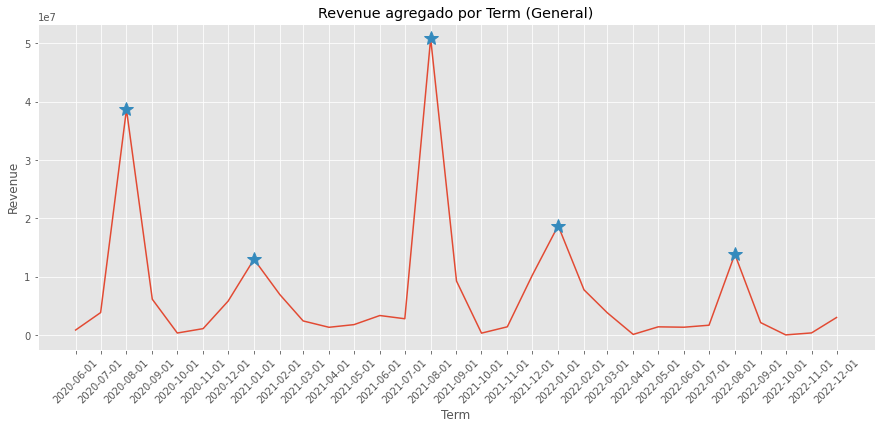

In [180]:
plt.figure(figsize=(15, 6))
agg_revenue_term = df.groupby('Term').sum()['Revenue']
ax = sns.lineplot(x=agg_revenue_term.index, y=agg_revenue_term)
ax.set_title('Revenue agregado por Term (General)');
plt.xticks(agg_revenue_term.index, rotation=45);

# Encontrar los máximos locales
peaks, _ = find_peaks(agg_revenue_term, distance=5);
# Plot the peaks
plt.plot(agg_revenue_term.index[peaks], agg_revenue_term[peaks], "*", markersize=15);


Vemos claramente que los picos del gráfico corresponden a los periodos de inicio de semestre. Lo primero que salta a la vista es que el patrón observado en los primeros 4 máximos no se repite con la última observación; esto no es un indicador de que las ventas de CENGAGE se hayan desplomado, sino que la base de datos de la que disponemos al momento de hacer este estudio no llega hasta la fecha más actual.